## Timeseries clustering

Time series clustering is to partition time series data into groups based on similarity or distance, so that time series in the same cluster are similar.

Methodology followed:
* Use Variational Recurrent AutoEncoder (VRAE) for dimensionality reduction of the timeseries
* To visualize the clusters, PCA and t-sne are used

Paper:
https://arxiv.org/pdf/1412.6581.pdf

#### Contents

1. [Import](#Import-required-modules)
2. [Load data and preprocess](#Load-data-and-preprocess)
3. [Initialize VRAE object](#Initialize-VRAE-object)
4. [Fit the model onto dataset](#Fit-the-model-onto-dataset)
5. [Transform the input timeseries to encoded latent vectors](#Transform-the-input-timeseries-to-encoded-latent-vectors)
6. [Save the model to be fetched later](#Save-the-model-to-be-fetched-later)

### Import required modules

In [90]:
from vrae.vrae import VRAE
from vrae.utils import *
from vrae.utils_EMG import *
import numpy as np
import torch
import pickle

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error as mse

import plotly
from torch.utils.data import DataLoader, TensorDataset
plotly.offline.init_notebook_mode()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Download dir

In [91]:
dload = './model_dir'

### Hyper parameters

In [92]:
seq_len = 10
hidden_size = 256
hidden_layer_depth = 3
latent_length = 16
batch_size = 32
learning_rate = 0.00002
n_epochs = 1500
dropout_rate = 0.0
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every=10
clip = True # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU
output = True

### Load data and preprocess

In [93]:
training_file = ['20201020_Pop_Cage_001','20201020_Pop_Cage_002','20201020_Pop_Cage_003','20201020_Pop_Cage_004',
                '20201020_Pop_Cage_006']
X_train, y_train = load_data(direc = 'data', dataset="EMG", all_file = training_file,
                         do_pca = False, single_channel = None, 
                         batch_size = batch_size, seq_len = seq_len, pca_component = 6)
train_dataset = TensorDataset(torch.from_numpy(X_train))

Loading 20201020_Pop_Cage_001, X shape (3599, 150, 1), y shape (3599, 1), has label [-1.  0.  1.  2.  3.]
Loading 20201020_Pop_Cage_002, X shape (3599, 150, 1), y shape (3599, 1), has label [-1.  0.  1.  2.  3.]
Loading 20201020_Pop_Cage_003, X shape (3599, 150, 1), y shape (3599, 1), has label [-1.  0.  1.  2.  3.  4.]
Loading 20201020_Pop_Cage_004, X shape (3601, 150, 1), y shape (3601, 1), has label [-1.  0.  1.  2.  3.  4.]
Loading 20201020_Pop_Cage_006, X shape (3599, 150, 1), y shape (3599, 1), has label [-1.  0.  1.  2.  3.  4.]
Dataset shape: (17984, 10, 15)
Label: [-1.  0.  1.  2.  3.  4.], shape: (17984, 1)


In [94]:
num_features = X_train.shape[2]

### Initialize VRAE object

VRAE inherits from `sklearn.base.BaseEstimator` and overrides `fit`, `transform` and `fit_transform` functions, similar to sklearn modules

In [95]:
from vrae.vrae import VRAE
vrae = VRAE(sequence_length=seq_len,
            number_of_features = num_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            optimizer = optimizer, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            loss = loss,
            block = block,
            dload = dload,
            output = output)

/home/roton2/miniconda3/envs/emg/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning:

size_average and reduce args will be deprecated, please use reduction='sum' instead.



### Fit the model onto dataset

In [50]:
#vrae.fit(train_dataset)

#If the model has to be saved, with the learnt parameters use:
vrae.fit(train_dataset)

Epoch: 9
Average loss: 5569730.0682
Epoch: 19
Average loss: 3732458.4848
Epoch: 29
Average loss: 2653692.3193
Epoch: 39
Average loss: 1980907.2225
Epoch: 49
Average loss: 1529497.8174
Epoch: 59
Average loss: 1236365.2767
Epoch: 69
Average loss: 1027439.0582
Epoch: 79
Average loss: 881177.5116
Epoch: 89
Average loss: 780301.0065
Epoch: 99
Average loss: 705758.5085
Epoch: 109
Average loss: 649304.0436
Epoch: 119
Average loss: 607651.4351
Epoch: 129
Average loss: 574628.2849
Epoch: 139
Average loss: 548216.1422
Epoch: 149
Average loss: 526444.9694
Epoch: 159
Average loss: 507821.9211
Epoch: 169
Average loss: 492410.0023
Epoch: 179
Average loss: 479200.3794
Epoch: 189
Average loss: 467370.3477
Epoch: 199
Average loss: 456903.0827
Epoch: 209
Average loss: 447540.3084
Epoch: 219
Average loss: 438803.0714
Epoch: 229
Average loss: 430883.0339
Epoch: 239
Average loss: 423330.4571
Epoch: 249
Average loss: 416496.0257
Epoch: 259
Average loss: 409704.3448
Epoch: 269
Average loss: 403419.8486
Epoch

### Plot loss and MSE

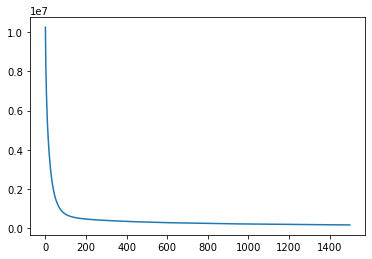

In [51]:
plt.plot(vrae.all_loss)

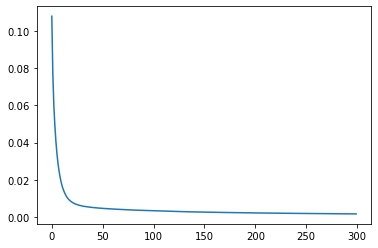

In [52]:
plt.plot(vrae.rec_mse)

### Transform the input timeseries to encoded latent vectors

In [53]:
#If the latent vectors have to be saved, pass the parameter `save`
z_run = vrae.transform(train_dataset, save = True, filename = 'z_run_e57_b32_z16_output.pkl')
z_run.shape

(17984, 16)

### Save / load the model

In [54]:
vrae.save('./vrae_e57_b32_z16_output.pth')

In [96]:
vrae.load(dload+'/vrae_e57_b32_z16_output.pth')
with open(dload+'/z_run_e57_b32_z16_output.pkl', 'rb') as fh:
    z_run = pickle.load(fh)

## Reconstruction

In [97]:
reconstruction = recon(vrae, X_train)

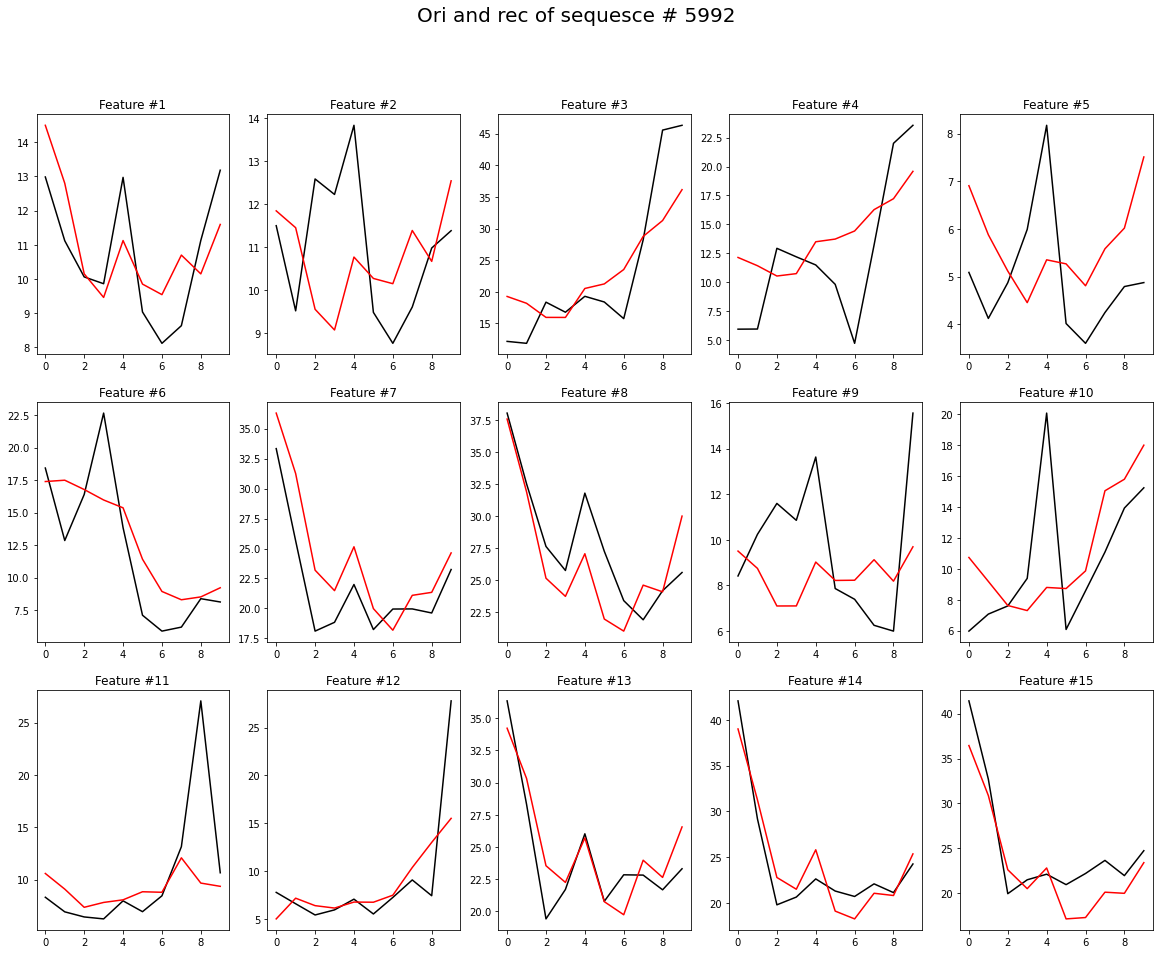

In [98]:
plot_recon_feature(X_train, reconstruction, idx = None)

Channel 1, corr = 0.7110, mse = 33.716799, mean = 29.5886.
Channel 2, corr = 0.6771, mse = 29.756823, mean = 27.4895.
Channel 3, corr = 0.6532, mse = 41.490045, mean = 31.6063.
Channel 4, corr = 0.5767, mse = 27.503560, mean = 19.6259.
Channel 5, corr = 0.6052, mse = 19.172670, mean = 13.4139.
Channel 6, corr = 0.6542, mse = 36.484139, mean = 32.0427.
Channel 7, corr = 0.8390, mse = 36.721060, mean = 49.2383.
Channel 8, corr = 0.8267, mse = 45.209181, mean = 54.5515.
Channel 9, corr = 0.6626, mse = 22.393672, mean = 21.3511.
Channel 10, corr = 0.7023, mse = 36.437465, mean = 30.8874.
Channel 11, corr = 0.8226, mse = 24.789751, mean = 46.5397.
Channel 12, corr = 0.6438, mse = 31.463966, mean = 21.5676.
Channel 13, corr = 0.8610, mse = 33.888693, mean = 50.0767.
Channel 14, corr = 0.8048, mse = 34.835835, mean = 39.4550.
Channel 15, corr = 0.7677, mse = 35.170939, mean = 36.4381.


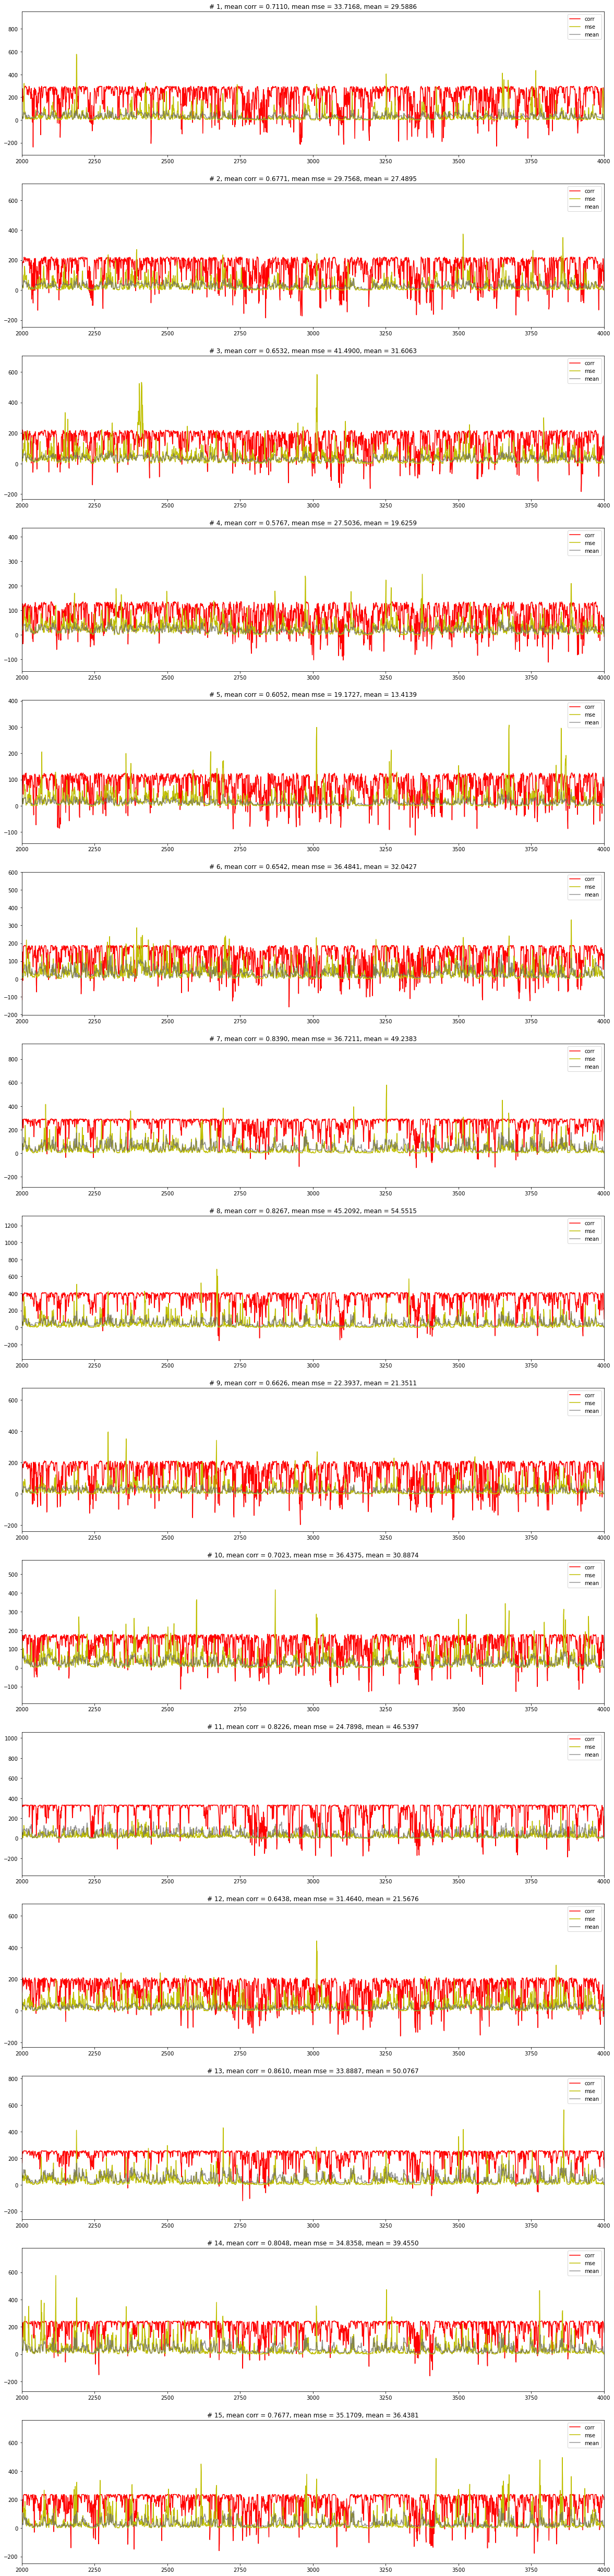

In [99]:
_, _, _ = plot_recon_metrics(X_train, reconstruction, x_lim = [2000, 4000])

### Convert PC back to channel traces

In [20]:
# recon_channel = pca_inverse(X_pca, reconstruction)

In [108]:
# plot_recon_feature(X_train_ori, recon_channel, idx = None)

In [109]:
# _, _, _ = plot_recon_metrics(X_train_ori, recon_channel, x_lim = [0, 2000])

## Reconstruction of test dataset

In [100]:
testing_file = ['20201020_Pop_Cage_005', '20201020_Pop_Cage_007']
X_test, y_test = load_data(direc = 'data', dataset="EMG", all_file = testing_file,
                         do_pca = False, single_channel = None, 
                         batch_size = batch_size, seq_len = seq_len, pca_component = 6)

Loading 20201020_Pop_Cage_005, X shape (3599, 150, 1), y shape (3599, 1), has label [-1.  0.  1.  2.  3.  5.]
Loading 20201020_Pop_Cage_007, X shape (3599, 150, 1), y shape (3599, 1), has label [-1.  0.  1.  2.  3.  4.]
Dataset shape: (7168, 10, 15)
Label: [-1.  0.  1.  2.  3.  4.  5.], shape: (7168, 1)


In [101]:
# Uncomment if using pca

recon_test = recon(vrae, X_test)
# recon_channel_test = pca_inverse(test_pca, recon_test)

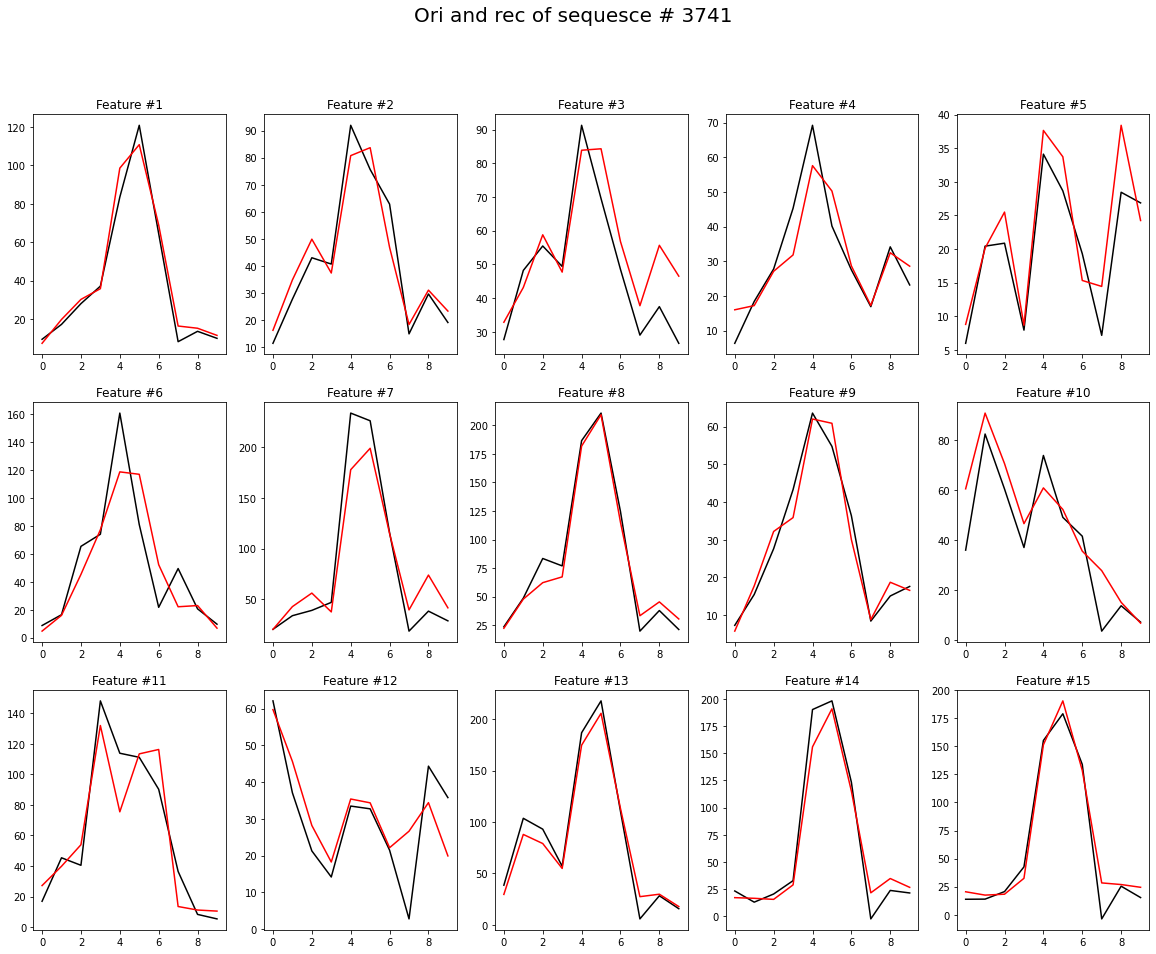

In [102]:
plot_recon_feature(X_test, recon_test, idx = None)
# plot_recon_feature(X_test_ori, recon_channel_test, idx = None)

Channel 1, corr = 0.6121, mse = 83.637991, mean = 29.5584.
Channel 2, corr = 0.5813, mse = 66.471095, mean = 27.4149.
Channel 3, corr = 0.5066, mse = 103.552847, mean = 32.5453.
Channel 4, corr = 0.4664, mse = 45.278386, mean = 19.5454.
Channel 5, corr = 0.4905, mse = 34.796398, mean = 13.0227.
Channel 6, corr = 0.4526, mse = 195.371225, mean = 30.9896.
Channel 7, corr = 0.7110, mse = 222.719560, mean = 50.5355.
Channel 8, corr = 0.7134, mse = 208.347560, mean = 55.5833.
Channel 9, corr = 0.5677, mse = 44.837757, mean = 20.8698.
Channel 10, corr = 0.5782, mse = 114.562752, mean = 31.7638.
Channel 11, corr = 0.6755, mse = 413.536354, mean = 46.6334.
Channel 12, corr = 0.4841, mse = 95.617897, mean = 21.2069.
Channel 13, corr = 0.7538, mse = 189.899586, mean = 52.4404.
Channel 14, corr = 0.6541, mse = 186.663401, mean = 41.4571.
Channel 15, corr = 0.6191, mse = 176.365483, mean = 38.8859.


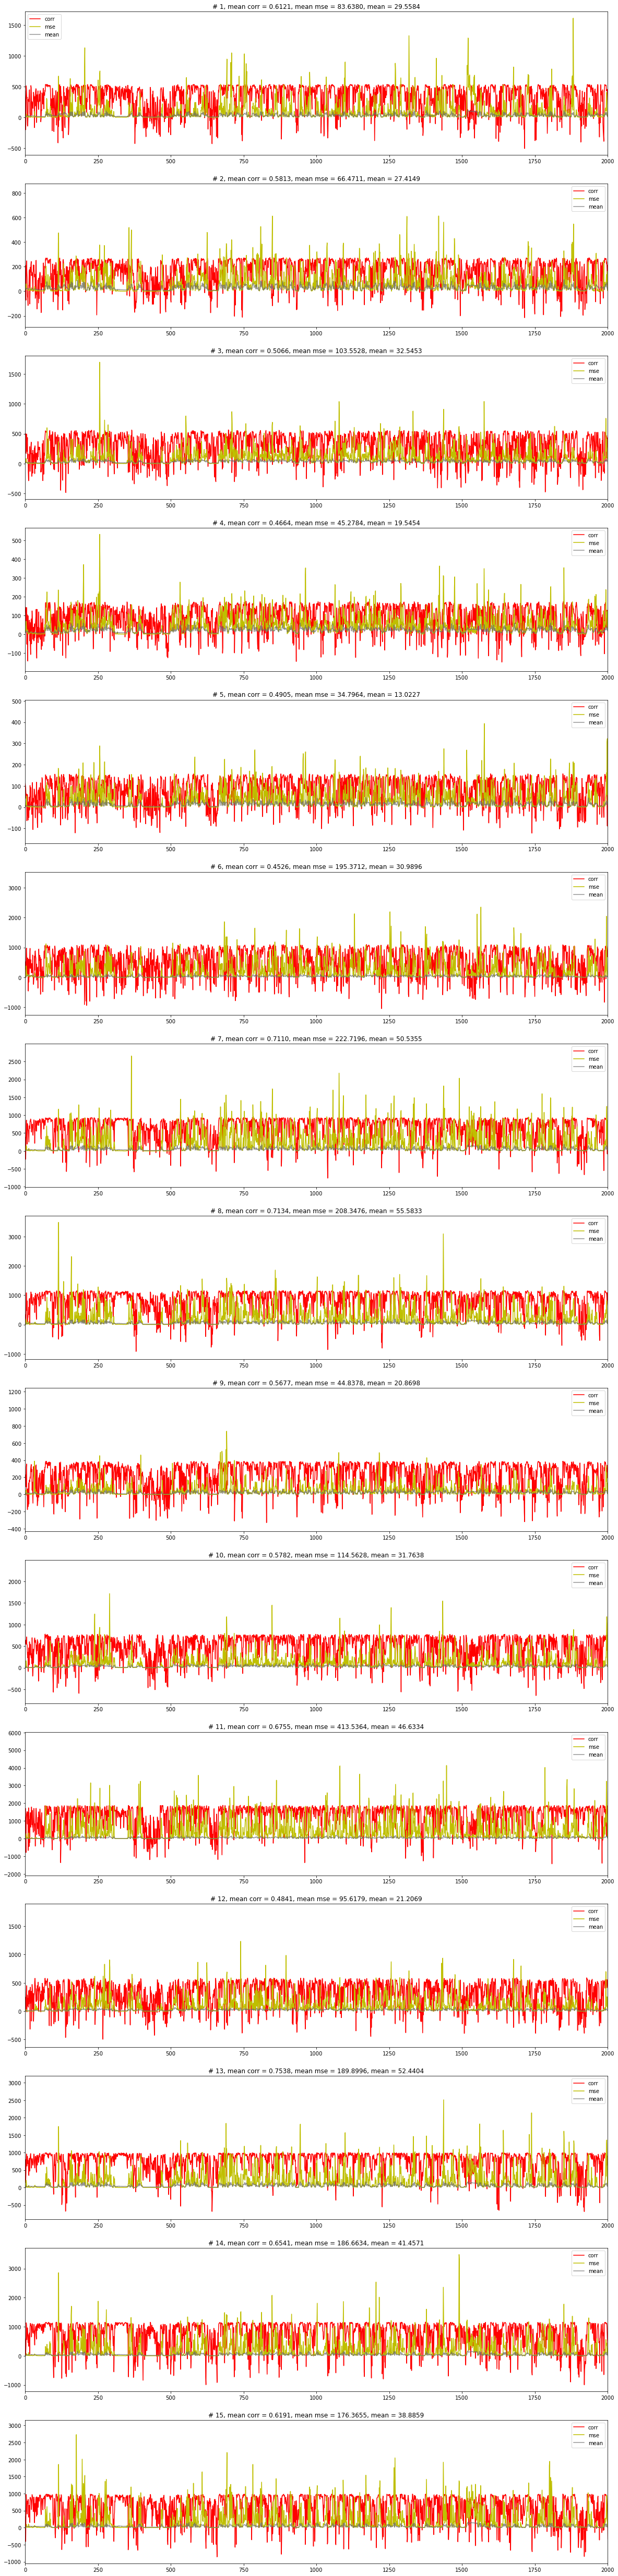

In [103]:
corr_mean, mse_mean, mean_mean = plot_recon_metrics(X_test, recon_test, x_lim = [0, 2000])
# corr_mean, mse_mean, mean_mean = plot_recon_metrics(X_test_ori, recon_channel_test, x_lim = [0, 2000])

In [104]:
print(list(corr_mean))
print(list(mse_mean))
print(list(mean_mean))

[0.6121488314468478, 0.5813439248928324, 0.5066102433964742, 0.4664310554762077, 0.4905492008347983, 0.45256908809767626, 0.710976250229428, 0.713378460854995, 0.5676987138026933, 0.5782117262560403, 0.6755104586927148, 0.4840726203855586, 0.7538127126198424, 0.6540542175087454, 0.619116153191103]
[83.63799096488783, 66.47109541384013, 103.55284714716143, 45.27838585366898, 34.79639797395836, 195.37122479627513, 222.71955955419048, 208.34756018990512, 44.83775731175517, 114.56275163804216, 413.5363541639645, 95.61789735507624, 189.8995862884719, 186.66340084516858, 176.3654830970523]
[29.558443014706768, 27.414924678304136, 32.54528668084857, 19.545427740051515, 13.022679916323572, 30.98961445901738, 50.535490176304165, 55.58334129172573, 20.86980557166033, 31.763762002375774, 46.63335753107305, 21.206949619877204, 52.44043212360176, 41.45713725737416, 38.88586835658078]


## Visualize latent space using PCA and tSNE

In [105]:
bhvs = {'crawling': np.array([0]),
        'high picking treats': np.array([1]),
        'low picking treats': np.array([2]),
        'pg': np.array([3]),
        'sitting still': np.array([4]),
        'grooming': np.array([5]),
        'no_behavior': np.array([-1])}

inv_bhvs = {int(v): k for k, v in bhvs.items()}

In [106]:
test_dataset = TensorDataset(torch.from_numpy(X_test))
z_run_test = vrae.transform(test_dataset, save = False)
z_run_all = np.vstack((z_run, z_run_test))
y_all = np.vstack((y_train, y_test))

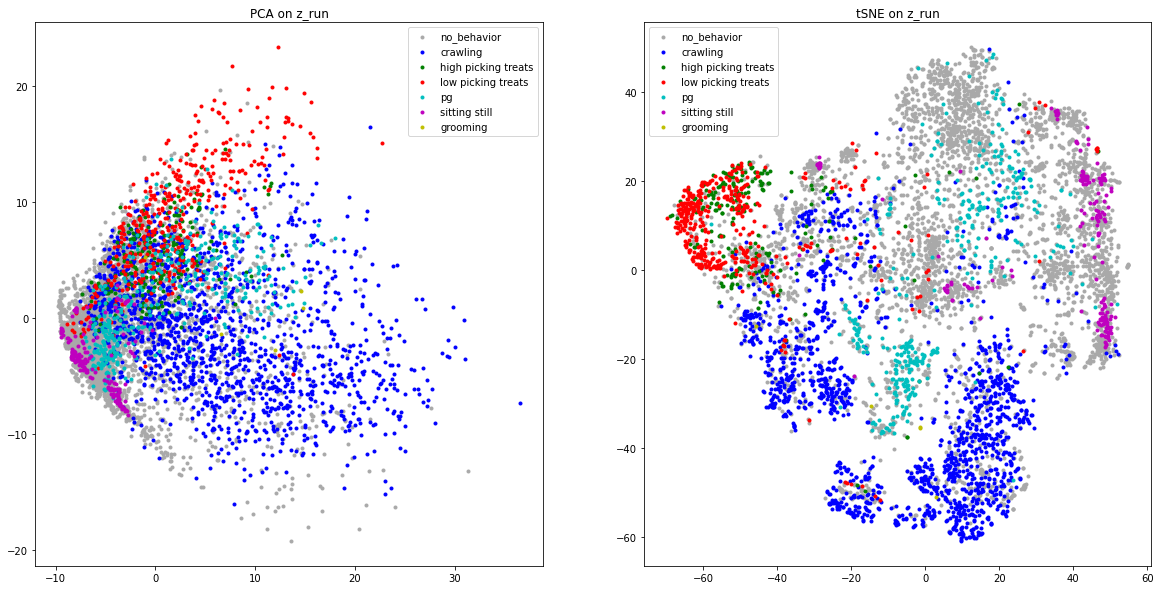

In [107]:
visualize(z_run = z_run_all, y = y_all, inv_bhvs = inv_bhvs, one_in = 4)